In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations
from scipy.stats import pearsonr
import ast

In [2]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [3]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [4]:
def fig_to_panels(fig, axes, output_dir):
    # Save individual panels of a figure 
    
    for panel_name, ax in axes.items():
        # Extract the panel title
        panel_title = ax.get_title()

        # Sanitize the panel title to use in filenames
        safe_title = panel_title.replace(" ", "_").replace("/", "_").replace("\n", "_").lower()

        # Create the filename for the current panel
        output_file = os.path.join(output_dir,safe_title)

        # Adjust the bounding box to include everything (labels, titles, etc.)
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

        # Save the individual panel using the adjusted bounding box
        fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
        fig.savefig(output_file + '.png', bbox_inches=extent)

        print(f"Saved panel '{panel_title}' to {output_file}")


In [5]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

In [6]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

# Rewiring

In [7]:
parentdir = '/home/lnemati/pathway_crosstalk/results/flow'
metric = 'kme_cos'
# kme_dot_norm  kme_euclidean_similarity  kme_manhattan_similarity

dirs = ['ccc_lr_pairs', 'intact_direct', 'intact_physical', 'intact_association']
tvals = {}
nvals = {}
diff = {}

df = pd.DataFrame(columns=['Tissue', 'Condition', 'Type', 'Value'])

for int_type in dirs:
    
    tmp = os.path.join(parentdir, int_type, f'{metric}', 'tumor_values.csv')
    tmp = pd.read_csv(tmp)
    tmp = pd.melt(
        tmp, 
        id_vars=['interaction'],
        var_name='Tissue',
        value_name='Value'
    )
    tmp['Type'] = int_type
    tmp['Condition'] = 'Tumor'
    
    df = pd.concat([df, tmp])
    
    tmp = os.path.join(parentdir, int_type, f'{metric}', 'normal_values.csv')
    tmp = pd.read_csv(tmp)
    tmp = pd.melt(
        tmp, 
        id_vars=['interaction'],
        var_name='Tissue',
        value_name='Value'
    )
    tmp['Type'] = int_type
    tmp['Condition'] = 'Normal'
    
    df = pd.concat([df, tmp])
    
    #tvals[int_type] = df['avg_tumor']
    #nvals[int_type] = df['avg_normal']
    #diff[int_type] = df['diff']
    
# Remove not paired tissues
df = df[df['Tissue'] != "other_tissues"]

In [8]:
# Pivot the data to have Tumor and Normal as separate columns
df_pivot = df.pivot_table(
    index=['Tissue', 'Type', 'interaction'],  # Grouping columns
    columns='Condition',                     # Values to pivot
    values='Value'                           # Values to aggregate
).reset_index()

# Only keep those that have at least one tissue
df_pivot = df_pivot.query('Normal != 0 and Tumor != 0')

# Compute the difference between Tumor and Normal
df_pivot['Difference'] = df_pivot['Tumor'] - df_pivot['Normal']

diff = df_pivot.dropna(subset=['Tumor', 'Normal'])
diff = diff[(diff == 0).sum(1) == 0]

In [9]:
from scipy.stats import wilcoxon

pvals = {}
zstats = {}

for itype in diff.Type.unique():
    # We need to set alternative='greater' otherwise we won't know wether the statistic refers to the
    # ranks of differences above or below zero. However we are interested in both, so we run the test twice
    # to get the correct pvalues.
    zstat  = wilcoxon(diff.query('Type == @itype')['Difference'], method='approx', alternative='greater').zstatistic
    pval   = wilcoxon(diff.query('Type == @itype')['Difference'], method='approx', alternative='two-sided').pvalue
    pvals[itype] = pval
    zstats[itype] = zstat
    
zstats = pd.Series(zstats).sort_values(ascending=False)

# Prepare pivoted_df for violin plot
pivoted_df = diff.drop(columns='Difference').melt(
    id_vars=['Tissue', 'Type', 'interaction'],  # Adjusted id_vars
    value_vars=['Normal', 'Tumor'], 
    var_name='Condition', 
    value_name='Value'
)

In [10]:
pvals

{'ccc_lr_pairs': 1.3197366887490022e-95,
 'intact_association': 0.06306816945828381,
 'intact_direct': 0.11111508506989146,
 'intact_physical': 2.357477991256894e-09}

In [11]:
zstats

ccc_lr_pairs          20.746454
intact_physical        5.971039
intact_direct          1.593201
intact_association    -1.858711
dtype: float64

In [12]:
medians = pivoted_df.groupby(['Type', 'Condition'])['Value'].median()
low_quart = pivoted_df.groupby(['Type', 'Condition'])['Value'].quantile(0.25)
high_quart = pivoted_df.groupby(['Type', 'Condition'])['Value'].quantile(0.75)

In [13]:
# Aggregate Tissues together
tissuemeans = pivoted_df.groupby(['Type', 'Condition', 'Tissue'])['Value'].mean()
tissuemeans = tissuemeans.to_frame().reset_index()

# Wilcoxon
pvals = {}
zstats = {}

tissue_diffs = diff.groupby(['Type', 'Tissue'])['Difference'].mean().to_frame().reset_index()

for itype in tissue_diffs.Type.unique():
    # We need to set alternative='greater' otherwise we won't know wether the statistic refers to the
    # ranks of differences above or below zero. However we are interested in both, so we run the test twice
    # to get the correct pvalues
    zstat  = wilcoxon(tissue_diffs.query('Type == @itype')['Difference'], method='approx', alternative='greater').zstatistic
    pval   = wilcoxon(tissue_diffs.query('Type == @itype')['Difference'], method='approx', alternative='two-sided').pvalue
    pvals[itype] = pval
    zstats[itype] = zstat
    
# Multiple hypothesis testing
pval_adj = false_discovery_control(list(pvals.values()))
pval_adj = pd.Series(pval_adj, index=pvals.keys())

In [14]:
pval_adj

ccc_lr_pairs          0.010443
intact_association    1.000000
intact_direct         0.281969
intact_physical       0.281969
dtype: float64

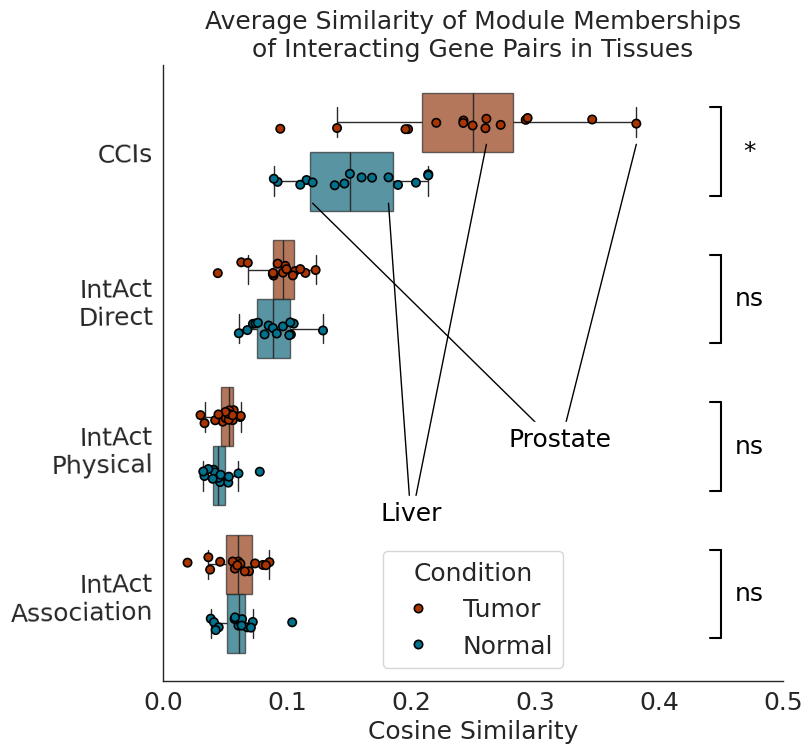

In [15]:
fs = 18  # Font size

# Ensure max_value is defined
order = ['ccc_lr_pairs', 'intact_direct', 'intact_physical', 'intact_association']
labels = ['CCIs', 'IntAct\nDirect', 'IntAct\nPhysical', 'IntAct\nAssociation']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot the horizontal boxplot (without outliers)
sns.boxplot(
    data=tissuemeans,
    y="Type",
    x="Value",
    hue="Condition",
    hue_order=["Tumor", "Normal"],
    palette={"Normal": ncolor, "Tumor": tcolor},
    order=order,
    boxprops={"alpha": 0.7},
    showfliers=False,  # Hide outliers
    ax=ax,
    legend=False
)

# Overlay actual data points with jitter for better visibility
sns.stripplot(
    data=tissuemeans,
    y="Type",
    x="Value",
    hue="Condition",
    hue_order=["Tumor", "Normal"],
    palette={"Normal": ncolor, "Tumor": tcolor},
    order=order,
    dodge=True,
    jitter=True,
    size=6,
    edgecolor="black",
    linewidth=1.2,
    ax=ax
)

# ANNOTATE PROSTATE
prostate_points = tissuemeans.query('Tissue == "prostate" and Type == "ccc_lr_pairs"')
text_x = 0.32
text_y = 2

for _, row in prostate_points.iterrows():
    x_value = row["Value"]
    y_value = order.index(row["Type"])  
    offset = 0.35 if row['Condition'] == 'Normal' else -0.05

    ax.plot([x_value, text_x], [y_value + offset, text_y], "black", linestyle='-', linewidth=1, zorder=9)

ax.text(text_x, text_y, "Prostate", fontsize=fs, color="black", ha='center',
        bbox=dict(facecolor="white", edgecolor="white", boxstyle=None), zorder=10)

# ANNOTATE LIVER
liver_points = tissuemeans.query('Tissue == "liver" and Type == "ccc_lr_pairs"')
text_x = 0.2
text_y = 2.5

for _, row in liver_points.iterrows():
    x_value = row["Value"]
    y_value = order.index(row["Type"])
    offset = 0.35 if row['Condition'] == 'Normal' else -0.05

    ax.plot([x_value, text_x], [y_value + offset, text_y], "black", linestyle='-', linewidth=1, zorder=9)

ax.text(text_x, text_y, "Liver", fontsize=fs, color="black", ha='center',
        bbox=dict(facecolor="white", edgecolor="white", boxstyle=None), zorder=10)

# Ensure x-axis starts at 0
ax.set_xlim(0, 0.4)

# Set title
ax.set_title('Average Similarity of Module Memberships\nof Interacting Gene Pairs in Tissues', fontsize=fs)

# Set x-axis label
ax.set_xlabel('Cosine Similarity', fontsize=fs)

# Set y-axis labels
ax.set_yticks(range(len(order)))
ax.set_yticklabels(labels, fontsize=fs, rotation=1, ha='right')

# Remove unnecessary spines
ax.spines[['right', 'top']].set_visible(False)

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=fs)

# Adjust legend font size and location
legend = ax.legend(fontsize=fs, loc='lower right')
legend.set_title("Condition", prop={'size': fs})


# Add vertical significance bars

pos = 0.45 # horizontal position of significance bar

for i, interaction_type in enumerate(order):
    # Check if the p-value for the current interaction type is significant
    y_position = i  # Corresponding y-axis position
    pval = pval_adj[interaction_type]

    # Draw significance bar
    ax.plot([pos, pos], [y_position - 0.3, y_position + 0.3], color='black', linestyle='-', zorder=9)
    ax.plot([0.98*pos, pos], [y_position - 0.3, y_position - 0.3], color='black', linestyle='-', zorder=9)
    ax.plot([0.98*pos, pos], [y_position + 0.3, y_position + 0.3], color='black', linestyle='-', zorder=9)
    
    label = 'ns' 
    label = '*' if pval  < 0.05 else label
    label = '**' if pval < 0.01 else label
    
    # Annotate with p-value
    ax.text(1.05*pos, y_position+0.08, f'{label}', fontsize=fs, color='black', ha='center', va='bottom', zorder=10)

# Rest of your plotting code...
# Ensure x-axis starts at 0
ax.set_xlim(0, 0.5)

# Set title
ax.set_title('Average Similarity of Module Memberships\nof Interacting Gene Pairs in Tissues', fontsize=fs)

# Set x-axis label
ax.set_xlabel('Cosine Similarity', fontsize=fs)

# Set y-axis labels
ax.set_yticks(range(len(order)))
ax.set_yticklabels(labels, fontsize=fs, rotation=1, ha='right')

# Remove unnecessary spines
ax.spines[['right', 'top']].set_visible(False)

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=fs)

# Adjust legend font size and location
legend = ax.legend(fontsize=fs, loc='lower center')
legend.set_title("Condition", prop={'size': fs})

# Remove ylabel
ax.set_ylabel('')

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/rewiring_boxplot.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/rewiring_boxplot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [16]:
pval_adj

ccc_lr_pairs          0.010443
intact_association    1.000000
intact_direct         0.281969
intact_physical       0.281969
dtype: float64

In [17]:
interdf = pivoted_df.groupby(['Type', 'Condition', 'interaction'])['Value'].mean()
interdf = interdf.sort_values()[::-1]
interdf = interdf.to_frame().reset_index()
interdf.query('Type == "ccc_lr_pairs"')

,Type,Condition,interaction,Value
24,ccc_lr_pairs,Normal,AKR1D1_AR,0.995831
56,ccc_lr_pairs,Normal,APOA1_AMN,0.991600
58,ccc_lr_pairs,Normal,DBH_ADRA2B,0.991475
66,ccc_lr_pairs,Normal,DBH_ADRA1B,0.990875
99,ccc_lr_pairs,Normal,CYP11A1_NR1I2,0.987780
...,...,...,...,...
726904,ccc_lr_pairs,Normal,PTGES2_PTGER1,-0.947787
726986,ccc_lr_pairs,Tumor,PTGES3_PTGER1,-0.959807
727016,ccc_lr_pairs,Normal,APOA2_TYROBP,-0.965244
727037,ccc_lr_pairs,Normal,SULT1E1_PPARD,-0.968618


In [18]:
interdf

,Type,Condition,interaction,Value
0,intact_association,Normal,CALM1+CALM1,1.000000
1,intact_association,Tumor,CALM1+CALM1,1.000000
2,intact_direct,Normal,FGA+FGB,0.999874
3,intact_association,Normal,UGT2B7+UGT1A4,0.999561
4,intact_association,Normal,APOA1+TTR,0.999502
...,...,...,...,...
727131,intact_association,Normal,TARBP1+CREB3L3,-0.996637
727132,intact_association,Normal,MFSD12+SLC22A9,-0.996696
727133,intact_physical,Normal,DYNLT1+HSPB9,-0.997237
727134,intact_association,Normal,SERPINA3+MOGAT3,-0.997450


In [19]:
## fig_to_panels(fig, axes, '/home/lnemati/pathway_crosstalk/results/figures/rewiring/')

In [20]:
tissues = pivoted_df.Tissue.unique()
same_module = pd.read_csv('/home/lnemati/pathway_crosstalk/results/interactions_network/same_module_interactions_all_subtissues.csv')
same_module.loc[same_module.tissue == 'thyroid_gland', 'tissue'] = 'thyroid'
same_module = same_module.query('tissue in @tissues')
same_module = same_module.drop(columns='subtissue')

In [21]:
results = pd.DataFrame(columns=same_module.columns)

for (tissue, condition), df in same_module.groupby(['tissue', 'condition']):
    # Count occurrences in the same module
    mean_counts = df.set_index(['tissue', 'condition']).sum()
    # If more subtissues are present, check if the same module is in at least half of them
    mean_counts = mean_counts >= df.shape[0] / 2
    # Add back tissue and condition
    mean_counts['tissue'] = tissue
    mean_counts['condition'] = condition
    # Concatenate after resetting index
    mean_counts = mean_counts.to_frame().T.reset_index(drop=True)
    results = pd.concat([results, mean_counts], ignore_index=True)
    
results.head()


,tissue,condition,CDH1_ITGA2+ITGB1,CDH1_ITGAE+ITGB7,CDH1_KLRG1,CDH2_FCER2,CADM1_NECTIN3,CADM3_CADM1,CADM3_CADM4,CADM3_EPB41L1,...,LAMA2_ITGA1+ITGB1,LAMA3_ITGA1+ITGB1,LAMA4_ITGA1+ITGB1,LAMA5_ITGA1+ITGB1,LAMB1_ITGA1+ITGB1,LAMB2_ITGA1+ITGB1,LAMB3_ITGA1+ITGB1,LAMC1_ITGA1+ITGB1,LAMC2_ITGA1+ITGB1,LAMC3_ITGA1+ITGB1
0,adrenal_gland,normal,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,adrenal_gland,tumor,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,brain,normal,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,brain,tumor,True,False,False,False,True,True,True,True,...,False,False,True,False,True,False,False,True,False,False
4,breast,normal,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,True,False,False


In [22]:
# Initialize an empty list to store results for each tissue
summary_data = []

# Loop through each tissue and calculate the required values
for tissue, df in results.set_index('condition').groupby('tissue'):
    df = df.drop(columns='tissue')  # Drop the redundant 'tissue' column
    tot = df.shape[1]
    n = df.loc['normal'].sum()
    t = df.loc['tumor'].sum()
    both = sum(df.sum() == 2)
    n_only = n - both
    t_only = t - both
    none = tot - n_only - t_only - both
    
    # Append a dictionary with the calculated values
    summary_data.append({
        'tissue': tissue,
        'tumor_only': t_only,
        'normal_only': n_only,
        'both': both,
        'none': none
    })

# Create a DataFrame from the list of dictionaries
summary_df = pd.DataFrame(summary_data)

# Display the resulting DataFrame
print(summary_df.head(3))

          tissue  tumor_only  normal_only  both  none
0  adrenal_gland         115          146    21  3709
1          brain         398          152    64  3377
2         breast         197          270    38  3486


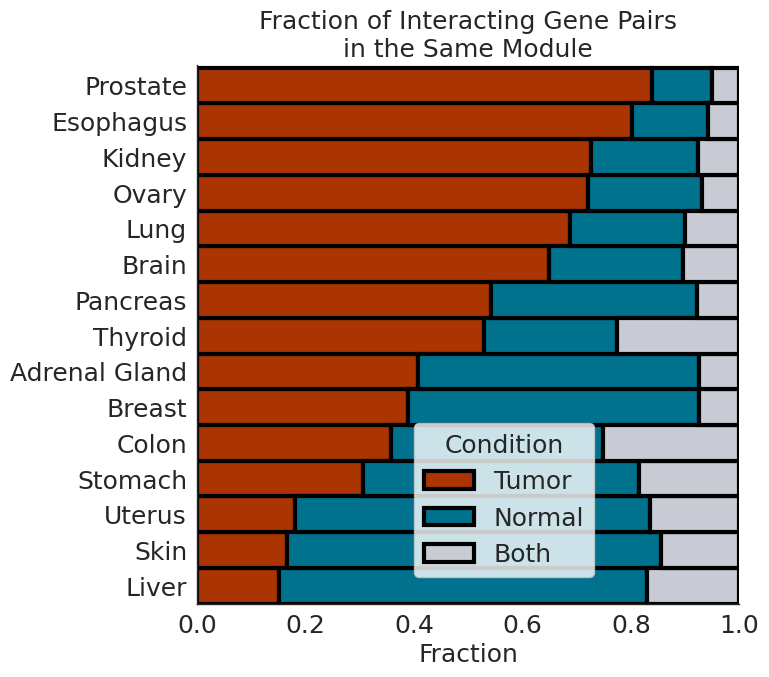

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fs=18

# Ensure tissue names are properly formatted
summary_df['tissue'] = summary_df['tissue'].str.replace('_', ' ').str.title()

# Exclude the 'none' category from calculations
summary_df['total'] = summary_df[['tumor_only', 'normal_only', 'both']].sum(axis=1)
for category in ['tumor_only', 'normal_only', 'both']:
    summary_df[category] = summary_df[category] / summary_df['total']

# Sort the DataFrame by the fraction of 'tumor_only'
summary_df = summary_df.sort_values(by='tumor_only', ascending=True)

# Plotting the horizontal stacked bar plot
categories = ['tumor_only', 'normal_only', 'both']  # Exclude 'none'
category_labels = ['Tumor', 'Normal', 'Both']  # Updated category names
colors = [tcolor, ncolor, lightgray]
tissues = summary_df['tissue']
data = summary_df[categories]

# Plot setup
fig, ax = plt.subplots(figsize=(7, 7))
y_positions = np.arange(len(tissues))

# Plot each category in the stacked bar
bottoms = np.zeros(len(tissues))
for idx, (category, label) in enumerate(zip(categories, category_labels)):
    ax.barh(
        y_positions,
        data[category],
        left=bottoms,
        label=label,
        height=1, # remove all space between bars
        color=colors[idx],  # Custom colors defined externally (tcolor, ncolor, lightgray)
        lw=3,
        edgecolor='k',
    )
    bottoms += data[category]

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(tissues)
ax.set_xlabel('Fraction', fontsize=fs)
ax.set_title('Fraction of Interacting Gene Pairs\nin the Same Module', fontsize=fs)
ax.legend(title='Condition', loc=(0.4, 0.05), title_fontsize=fs, fontsize=fs)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove white space between bars
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, len(tissues) - 0.42)

ax.tick_params(axis='both', which='major', labelsize=fs)

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/same_module_barplot.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/same_module_barplot.svg', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/same_module_barplot.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [24]:
diffs = {}

for tissue, tissuedf in tissuemeans.query('Type == "ccc_lr_pairs"').groupby('Tissue'):
    tissuedf = tissuedf.set_index('Condition')
    diffs[tissue] = tissuedf.loc['Tumor', 'Value'] - tissuedf.loc['Normal', 'Value']

diffs = pd.Series(diffs).sort_values()

In [25]:
diffs

kidney          -0.073562
adrenal_gland   -0.043911
pancreas         0.046121
skin             0.046930
thyroid          0.049245
ovary            0.068346
liver            0.078957
stomach          0.081113
brain            0.082179
lung             0.104515
esophagus        0.131010
uterus           0.131485
breast           0.200092
colon            0.230391
prostate         0.261027
dtype: float64

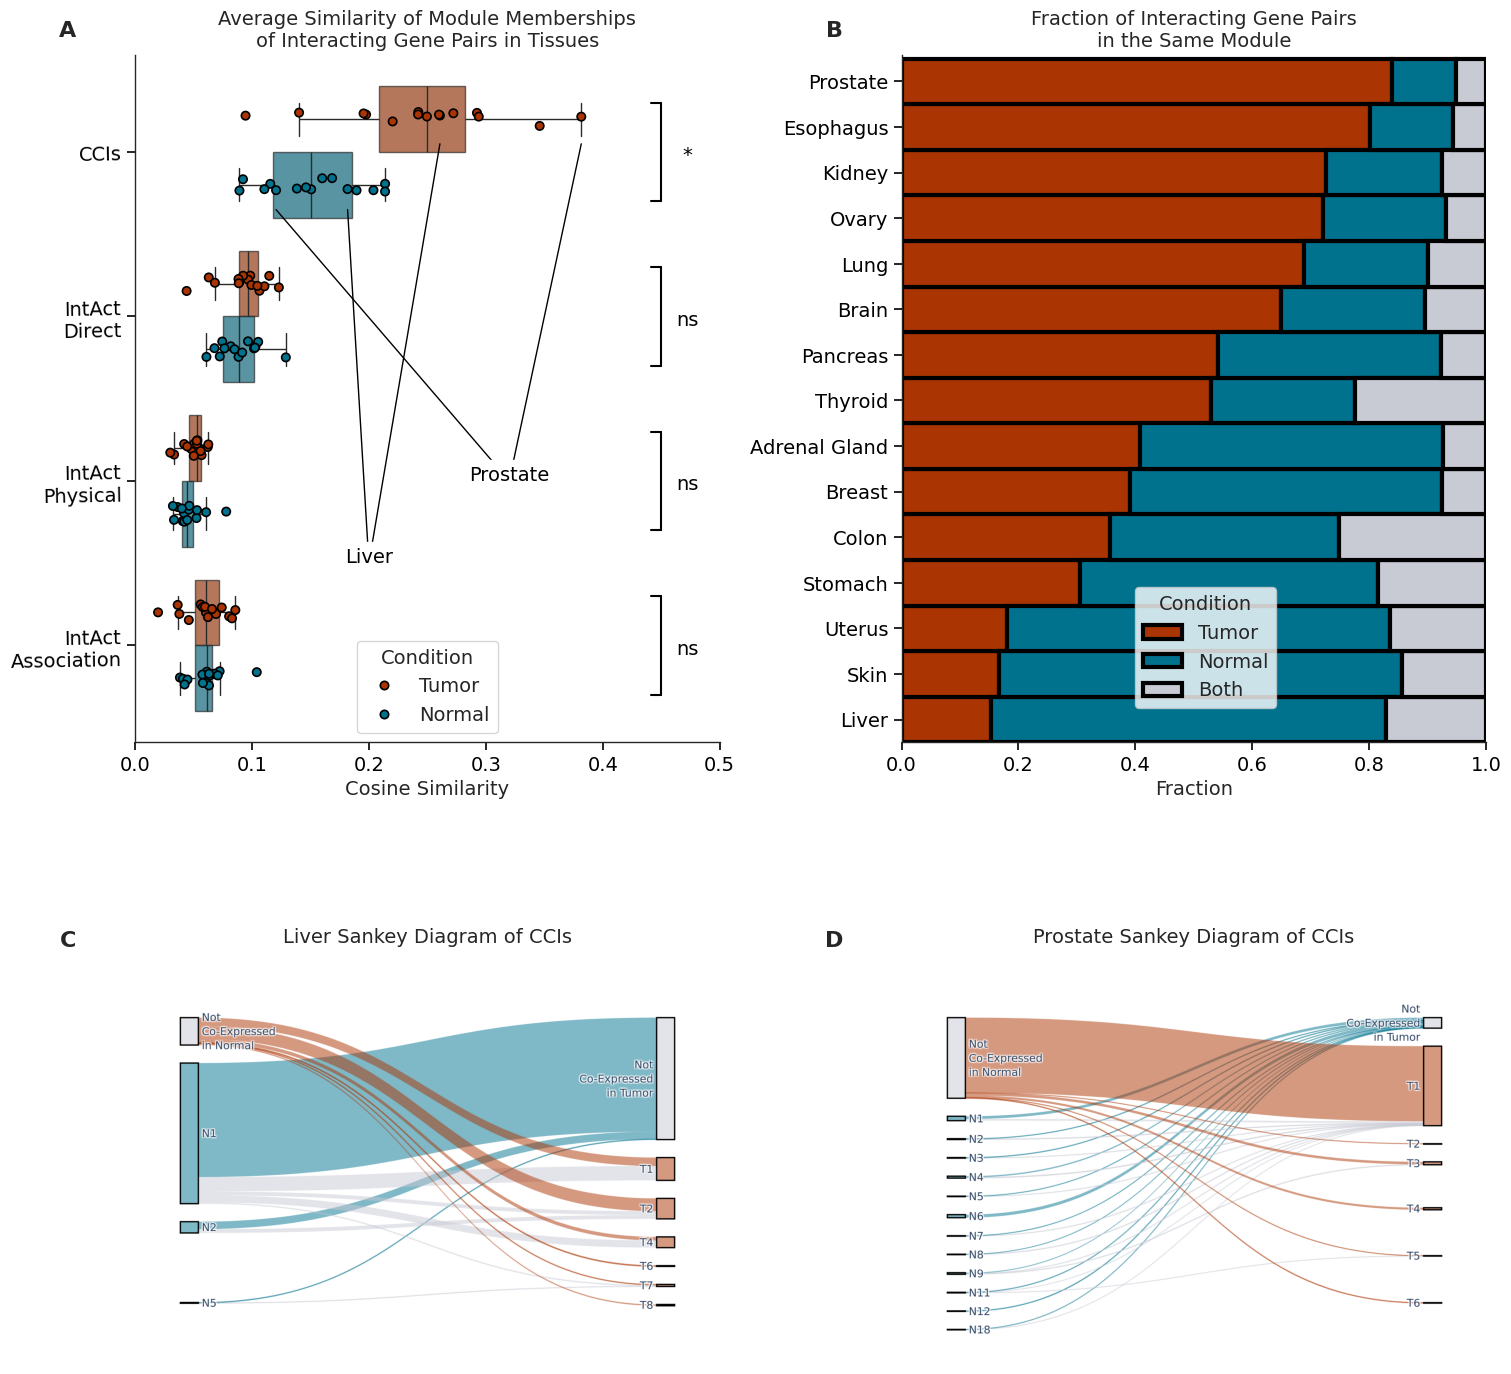

In [26]:
from PIL import Image, ImageChops
import matplotlib.image as mpimg

fs = 14

# Create the figure and the layout
fig, axs = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    figsize=(15, 15),
    constrained_layout=True
)

############# AXIS A: BOXPLOT ##############

ax = axs['A']

# Ensure max_value is defined
order = ['ccc_lr_pairs', 'intact_direct', 'intact_physical', 'intact_association']
labels = ['CCIs', 'IntAct\nDirect', 'IntAct\nPhysical', 'IntAct\nAssociation']

# Plot the horizontal boxplot (without outliers)
sns.boxplot(
    data=tissuemeans,
    y="Type",
    x="Value",
    hue="Condition",
    hue_order=["Tumor", "Normal"],
    palette={"Normal": ncolor, "Tumor": tcolor},
    order=order,
    boxprops={"alpha": 0.7},
    showfliers=False,  # Hide outliers
    ax=ax,
    legend=False
)

# Overlay actual data points with jitter for better visibility
sns.stripplot(
    data=tissuemeans,
    y="Type",
    x="Value",
    hue="Condition",
    hue_order=["Tumor", "Normal"],
    palette={"Normal": ncolor, "Tumor": tcolor},
    order=order,
    dodge=True,
    jitter=True,
    size=6,
    edgecolor="black",
    linewidth=1.2,
    ax=ax
)

# ANNOTATE PROSTATE
prostate_points = tissuemeans.query('Tissue == "prostate" and Type == "ccc_lr_pairs"')
text_x = 0.32
text_y = 2

for _, row in prostate_points.iterrows():
    x_value = row["Value"]
    y_value = order.index(row["Type"])  
    offset = 0.35 if row['Condition'] == 'Normal' else -0.05

    ax.plot([x_value, text_x], [y_value + offset, text_y], "black", linestyle='-', linewidth=1, zorder=9)

ax.text(text_x, text_y, "Prostate", fontsize=fs, color="black", ha='center',
        bbox=dict(facecolor="white", edgecolor="white", boxstyle=None), zorder=10)

# ANNOTATE LIVER
liver_points = tissuemeans.query('Tissue == "liver" and Type == "ccc_lr_pairs"')
text_x = 0.2
text_y = 2.5

for _, row in liver_points.iterrows():
    x_value = row["Value"]
    y_value = order.index(row["Type"])
    offset = 0.35 if row['Condition'] == 'Normal' else -0.05

    ax.plot([x_value, text_x], [y_value + offset, text_y], "black", linestyle='-', linewidth=1, zorder=9)

ax.text(text_x, text_y, "Liver", fontsize=fs, color="black", ha='center',
        bbox=dict(facecolor="white", edgecolor="white", boxstyle=None), zorder=10)

# Ensure x-axis starts at 0
ax.set_xlim(0, 0.4)

# Set title
ax.set_title('Average Similarity of Module Memberships\nof Interacting Gene Pairs in Tissues', fontsize=fs)

# Set x-axis label
ax.set_xlabel('Cosine Similarity', fontsize=fs)

# Set y-axis labels
ax.set_yticks(range(len(order)))
ax.set_yticklabels(labels, fontsize=fs, rotation=1, ha='right')

# Remove unnecessary spines
ax.spines[['right', 'top']].set_visible(False)

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=fs)

# Adjust legend font size and location
legend = ax.legend(fontsize=fs, loc='lower right')
legend.set_title("Condition", prop={'size': fs})


# Add vertical significance bars

pos = 0.45 # horizontal position of significance bar

for i, interaction_type in enumerate(order):
    # Check if the p-value for the current interaction type is significant
    y_position = i  # Corresponding y-axis position
    pval = pval_adj[interaction_type]

    # Draw significance bar
    ax.plot([pos, pos], [y_position - 0.3, y_position + 0.3], color='black', linestyle='-', zorder=9)
    ax.plot([0.98*pos, pos], [y_position - 0.3, y_position - 0.3], color='black', linestyle='-', zorder=9)
    ax.plot([0.98*pos, pos], [y_position + 0.3, y_position + 0.3], color='black', linestyle='-', zorder=9)
    
    label = 'ns' 
    label = '*' if pval  < 0.05 else label
    label = '**' if pval < 0.01 else label
    
    # Annotate with p-value
    ax.text(1.05*pos, y_position+0.08, f'{label}', fontsize=fs, color='black', ha='center', va='bottom', zorder=10)

# Rest of your plotting code...
# Ensure x-axis starts at 0
ax.set_xlim(0, 0.5)

# Set title
ax.set_title('Average Similarity of Module Memberships\nof Interacting Gene Pairs in Tissues', fontsize=fs)

# Set x-axis label
ax.set_xlabel('Cosine Similarity', fontsize=fs)

# Set y-axis labels
ax.set_yticks(range(len(order)))
ax.set_yticklabels(labels, fontsize=fs, rotation=1, ha='right')

# Remove unnecessary spines
ax.spines[['right', 'top']].set_visible(False)

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=fs)

# Adjust legend font size and location
legend = ax.legend(fontsize=fs, loc='lower center')
legend.set_title("Condition", prop={'size': fs})

# Remove ylabel
ax.set_ylabel('')


############# AXIS B: FREQUENCIES ###################

ax = axs['B']

# Ensure tissue names are properly formatted
summary_df['tissue'] = summary_df['tissue'].str.replace('_', ' ').str.title()

# Exclude the 'none' category from calculations
summary_df['total'] = summary_df[['tumor_only', 'normal_only', 'both']].sum(axis=1)
for category in ['tumor_only', 'normal_only', 'both']:
    summary_df[category] = summary_df[category] / summary_df['total']

# Sort the DataFrame by the fraction of 'tumor_only'
summary_df = summary_df.sort_values(by='tumor_only', ascending=True)

# Plotting the horizontal stacked bar plot
categories = ['tumor_only', 'normal_only', 'both']  # Exclude 'none'
category_labels = ['Tumor', 'Normal', 'Both']  # Updated category names
colors = [tcolor, ncolor, lightgray]
tissues = summary_df['tissue']
data = summary_df[categories]

# Plot setup
y_positions = np.arange(len(tissues))

# Plot each category in the stacked bar
bottoms = np.zeros(len(tissues))
for idx, (category, label) in enumerate(zip(categories, category_labels)):
    ax.barh(
        y_positions,
        data[category],
        left=bottoms,
        label=label,
        height=1, # remove all space between bars
        color=colors[idx],  # Custom colors defined externally (tcolor, ncolor, lightgray)
        lw=3,
        edgecolor='k',
    )
    bottoms += data[category]

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(tissues)
ax.set_xlabel('Fraction', fontsize=fs)
ax.set_title('Fraction of Interacting Gene Pairs\nin the Same Module', fontsize=fs)
ax.legend(title='Condition', loc=(0.4, 0.05), title_fontsize=fs, fontsize=fs)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove white space between bars
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, len(tissues) - 0.42)

ax.tick_params(axis='both', which='major', labelsize=fs)

def manual_crop_asymmetric(
    img: Image.Image,
    crop_left: int = 0,
    crop_right: int = 0,
    crop_top: int = 0,
    crop_bottom: int = 0
) -> Image.Image:
    """Crop specific pixels from each side."""
    width, height = img.size
    left = crop_left
    right = width - crop_right
    top = crop_top
    bottom = height - crop_bottom
    return img.crop((left, top, right, bottom))

# Define crop values
crop_left = 75
crop_right = crop_left
crop_top = 78
crop_bottom = 46

############# AXIS C: Sankey Image - Liver (asymmetric crop) ##############

ax = axs['C']
img_path_liver = "/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/figures/sankey.png"

img_liver = Image.open(img_path_liver).convert("RGB")
img_liver_cropped = manual_crop_asymmetric(
    img_liver,
    crop_left=crop_left,
    crop_right=crop_right,
    crop_top=crop_top,
    crop_bottom=crop_bottom
)
ax.imshow(img_liver_cropped)
ax.axis('off')
ax.set_title("Liver Sankey Diagram of CCIs", fontsize=fs)


############# AXIS D: Sankey Image - Prostate (asymmetric crop) ##############

ax = axs['D']
img_path_prostate = "/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/figures/sankey.png"

img_prostate = Image.open(img_path_prostate).convert("RGB")
img_prostate_cropped = manual_crop_asymmetric(
    img_prostate,
    crop_left=crop_left,
    crop_right=crop_right,
    crop_top=crop_top,
    crop_bottom=crop_bottom
)
ax.imshow(img_prostate_cropped)
ax.axis('off')
ax.set_title("Prostate Sankey Diagram of CCIs", fontsize=fs)

for ax in axs:
    axs[ax].xaxis.set_ticks_position('bottom')
    axs[ax].yaxis.set_ticks_position('left')
    axs[ax].get_xaxis().set_visible(True)
    axs[ax].get_yaxis().set_visible(True)

    axs[ax].tick_params(
        axis='both',
        which='both',
        labelsize=fs,
        direction='out',
        length=6,
        width=1.2,
        colors='black'
    )
    
ax = axs['A']
ax.text(-0.1, 1.05, 'A', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

ax = axs['B']
ax.text(-0.1, 1.05, 'B', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

ax = axs['C']
ax.text(-0.1, 1.05, 'C', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

ax = axs['D']
ax.text(-0.1, 1.05, 'D', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig4/fig4.svg', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig4/fig4.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig4/fig4.png', bbox_inches='tight', dpi=300)

# Show plot
plt.show()


In [27]:
fig_to_panels(fig, axs, output_dir='/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig4/panels')

Saved panel 'Average Similarity of Module Memberships
of Interacting Gene Pairs in Tissues' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig4/panels/average_similarity_of_module_memberships_of_interacting_gene_pairs_in_tissues
Saved panel 'Fraction of Interacting Gene Pairs
in the Same Module' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig4/panels/fraction_of_interacting_gene_pairs_in_the_same_module
Saved panel 'Liver Sankey Diagram of CCIs' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig4/panels/liver_sankey_diagram_of_ccis
Saved panel 'Prostate Sankey Diagram of CCIs' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig4/panels/prostate_sankey_diagram_of_ccis


# T Same / N Diff. & N Same / T Diff.

In [28]:
# Load hallmark gene sets
def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets

# Load hallmark data
hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

# Generate readable labels
labels = [label.replace('HALLMARK_', '').replace('_', ' ').title() for label in hallmarks.keys()]

# Mapping for special formatting
replace = {
    'Myc': 'MYC',
    'Kras': 'KRAS',
    'Il2': 'IL2',
    'Stat5': 'STAT5',
    'Il6': 'IL6',
    'Jak': 'JAK',
    'Stat3': 'STAT3',
    'P53': 'P53',
    'Tnfa': 'TNFα',
    'Nfkb': 'NF-κB',
    'Mtorc1': 'MTORC1',
    ' Dn': ' Down',
    'Epithelial Mesenchymal Transition': 'E-M Transition'
}

# Apply replacements to labels
for str1, str2 in replace.items():
    labels = [label.replace(str1, str2) for label in labels]

# Map original hallmark names to cleaned labels
hallmark_name_map = dict(zip(hallmarks.keys(), labels))

In [29]:
#bkg = '_with_background'
bkg = '_without_background'

# Liver
t_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/t_same_n_diff_enrichr'+bkg+'.csv')
t_enr = t_enr[t_enr['Adjusted P-value'] < 0.01]
#t_enr = t_enr.sort_values(by='Odds Ratio')
t_enr = t_enr.sort_values(by='P-value', ascending=False)
t_enr['Log Odds Ratio'] = np.log2(t_enr['Odds Ratio'])
t_enr['Term'] = t_enr.Term.map(hallmark_name_map)

n_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/n_same_t_diff_enrichr'+bkg+'.csv')
n_enr = n_enr[n_enr['Adjusted P-value'] < 0.01]
#n_enr = n_enr.sort_values(by='Odds Ratio')
n_enr = n_enr.sort_values(by='P-value', ascending=False)
n_enr['Log Odds Ratio'] = np.log2(n_enr['Odds Ratio'])
n_enr['Term'] = n_enr.Term.map(hallmark_name_map)


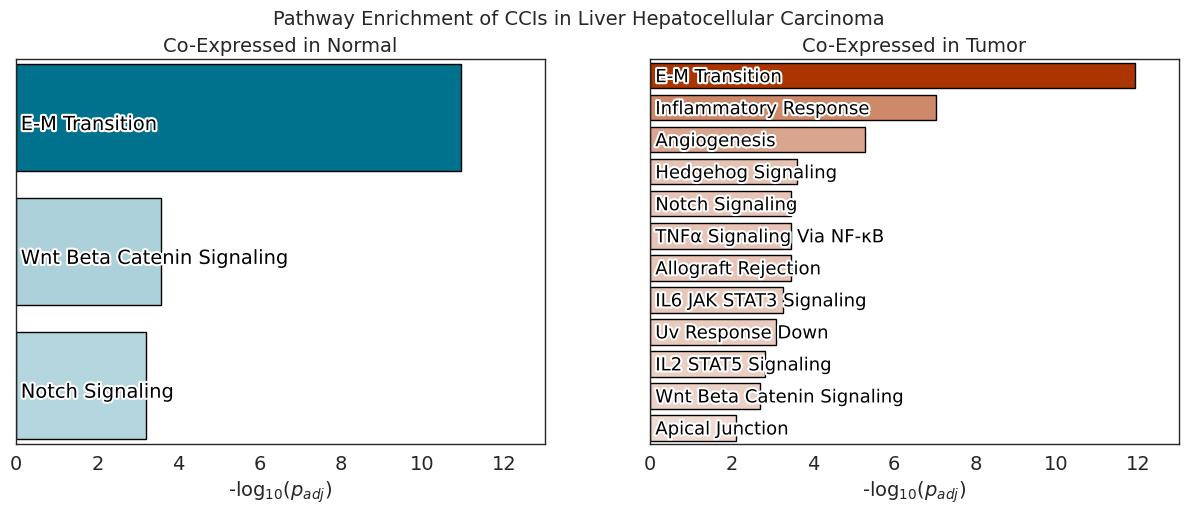

In [51]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patheffects as path_effects

fs = 14

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Pathway Enrichment of CCIs in Liver Hepatocellular Carcinoma', fontsize=fs)

x_offset = 0.01
y_offset = -0.05

# Compute -log10(pvalue) for the data
n_enr['-log10(pvalue)'] = -np.log10(n_enr["Adjusted P-value"])
t_enr['-log10(pvalue)'] = -np.log10(t_enr["Adjusted P-value"])

# Create colormap for first plot
cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", ncolor])
norm1 = mcolors.Normalize(vmin=0, vmax=n_enr["-log10(pvalue)"].max())
colors1 = cmap1(norm1(n_enr["-log10(pvalue)"].values))

bars1 = ax1.barh(n_enr["Term"], n_enr["-log10(pvalue)"], color=colors1, edgecolor='k', lw=1)
ax1.set_title('Co-Expressed in Normal', fontsize=fs)
ax1.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim1 = ax1.get_xlim()[1]
for bar, label in zip(bars1, n_enr["Term"]):
    text = ax1.text(x_offset * xlim1, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=fs, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
ylim1, ylim2 = ax1.get_ylim()
ax1.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Create colormap for second plot
cmap2 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", tcolor])
norm2 = mcolors.Normalize(vmin=0, vmax=t_enr["-log10(pvalue)"].max())
colors2 = cmap2(norm2(t_enr["-log10(pvalue)"].values))

bars2 = ax2.barh(t_enr["Term"], t_enr["-log10(pvalue)"], color=colors2, edgecolor='k', lw=1)
ax2.set_title('Co-Expressed in Tumor', fontsize=fs)
ax2.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax2.tick_params(labelsize=fs)
ax2.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim2 = ax2.get_xlim()[1]
for bar, label in zip(bars2, t_enr["Term"]):
    text = ax2.text(x_offset * xlim2, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax2.get_ylim()
ax2.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Set the same xlim for both axes based on the max of -log10(pvalue)
xlim1 = round(1 + n_enr['-log10(pvalue)'].max())
xlim2 = round(1 + t_enr['-log10(pvalue)'].max())
ax1.set_xlim(0, max(xlim1, xlim2))
ax2.set_xlim(0, max(xlim1, xlim2))

# Uncomment to save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/liver_enrichment.png', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/liver_enrichment.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/supplementary/liver_enrichment.png', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/supplementary/liver_enrichment.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [52]:
# Prostate
t_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/t_same_n_diff_enrichr'+bkg+'.csv')
t_enr = t_enr[t_enr['Adjusted P-value'] < 0.01]
#t_enr = t_enr.sort_values(by='Odds Ratio')
t_enr = t_enr.sort_values(by='P-value', ascending=False)
t_enr['Log Odds Ratio'] = np.log2(t_enr['Odds Ratio'])
t_enr['Term'] = t_enr.Term.map(hallmark_name_map)

n_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/n_same_t_diff_enrichr'+bkg+'.csv')
n_enr = n_enr[n_enr['Adjusted P-value'] < 0.01]
#n_enr = n_enr.sort_values(by='Odds Ratio')
n_enr = n_enr.sort_values(by='P-value', ascending=False)
n_enr['Log Odds Ratio'] = np.log2(n_enr['Odds Ratio'])
n_enr['Term'] = n_enr.Term.map(hallmark_name_map)


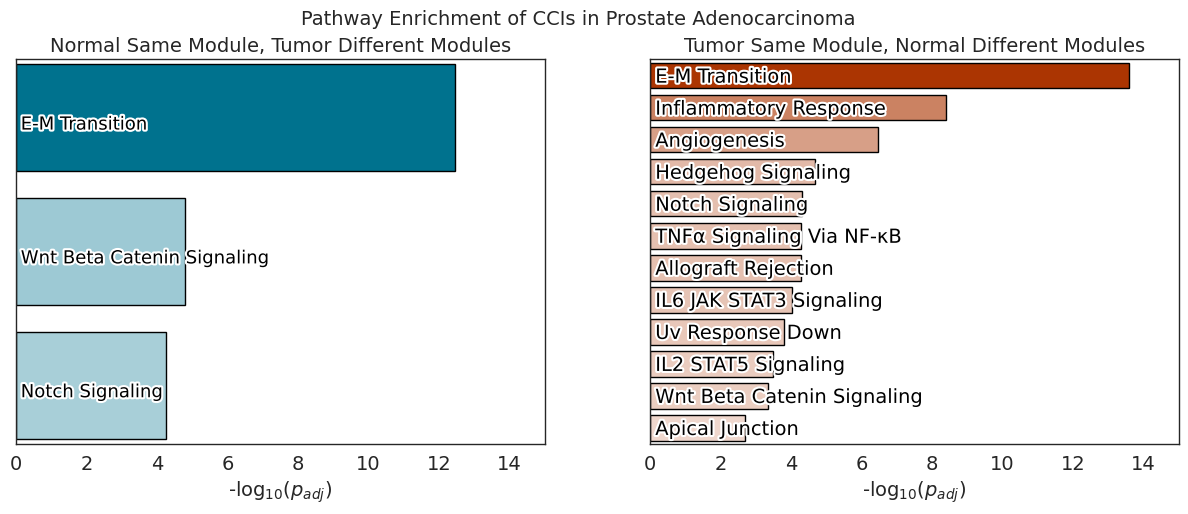

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patheffects as path_effects

fs = 14 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Pathway Enrichment of CCIs in Prostate Adenocarcinoma', fontsize=fs)

x_offset = 0.01
y_offset = -0.05

# Compute -log10(pvalue) for the data
n_enr['-log10(pvalue)'] = -np.log10(n_enr["P-value"])
t_enr['-log10(pvalue)'] = -np.log10(t_enr["P-value"])

# Create colormap for first plot
cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", ncolor])
norm1 = mcolors.Normalize(vmin=0, vmax=n_enr["-log10(pvalue)"].max())
colors1 = cmap1(norm1(n_enr["-log10(pvalue)"].values))

bars1 = ax1.barh(n_enr["Term"], n_enr["-log10(pvalue)"], color=colors1, edgecolor='k', lw=1)
ax1.set_title('Normal Same Module, Tumor Different Modules', fontsize=fs)
ax1.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim1 = ax1.get_xlim()[1]
for bar, label in zip(bars1, n_enr["Term"]):
    text = ax1.text(x_offset * xlim1, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax1.get_ylim()
ax1.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Create colormap for second plot
cmap2 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", tcolor])
norm2 = mcolors.Normalize(vmin=0, vmax=t_enr["-log10(pvalue)"].max())
colors2 = cmap2(norm2(t_enr["-log10(pvalue)"].values))

bars2 = ax2.barh(t_enr["Term"], t_enr["-log10(pvalue)"], color=colors2, edgecolor='k', lw=1)
ax2.set_title('Tumor Same Module, Normal Different Modules', fontsize=fs)
ax2.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax2.tick_params(labelsize=fs)
ax2.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim2 = ax2.get_xlim()[1]
for bar, label in zip(bars2, t_enr["Term"]):
    text = ax2.text(x_offset * xlim2, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=fs, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax2.get_ylim()
ax2.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Set the same xlim for both axes based on the max of -log10(pvalue)
xlim1 = round(1 + n_enr['-log10(pvalue)'].max())
xlim2 = round(1 + t_enr['-log10(pvalue)'].max())
ax1.set_xlim(0, max(xlim1, xlim2))
ax2.set_xlim(0, max(xlim1, xlim2))

# Uncomment to save the figure
plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/prostate_enrichment.png', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/prostate_enrichment.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/supplementary/prostate_enrichment.png', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/supplementary/prostate_enrichment.pdf', dpi=300, bbox_inches='tight')

plt.show()

# E-M Transition Network

In [36]:
# Load hallmark gene sets
def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets

# Load hallmark data
hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

prostate_tumor_wgcna = PyWGCNA.readWGCNA('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/wgcna_prostate_adenocarcinoma.p')
prostate_normal_wgcna = PyWGCNA.readWGCNA('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/normal/prostate/wgcna_prostate.p')

Reading wgcna_prostate_adenocarcinoma WGCNA done!
Reading wgcna_prostate WGCNA done!


In [37]:
all_em_genes = list(hallmarks['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION'])

ccc = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc.csv')
ccc['complex_a'] = ccc.complex_a.apply(ast.literal_eval)
ccc['complex_b'] = ccc.complex_b.apply(ast.literal_eval)
ccc['all_genes'] = ccc.all_genes.apply(ast.literal_eval)

ccc['em_connect'] = ccc.all_genes.apply(lambda x: len(set(x).intersection(all_em_genes)) > 0)
ccc = ccc[ccc['em_connect']]
ccc_genes = list(set(ccc.all_genes.sum()))
     
all_genes = list(set(ccc_genes + all_em_genes))

In [38]:
import pandas as pd
import numpy as np

def compute_emt_edgelist(wgcna, hallmarks, label=''):
    """
    Compute edgelist for EMT hallmark genes based on module membership, correlation, and adjacency.

    Parameters:
    -----------
    wgcna : PyWGCNA object
        The WGCNA object (e.g., tumor or normal).
    hallmarks : dict
        Dictionary of hallmark gene sets.
    label : str
        Label prefix for column names (e.g., 'tumor' or 'normal').

    Returns:
    --------
    edgelist : pd.DataFrame
        DataFrame with MultiIndex (gene1, gene2) and columns:
        - {label}_same_module
        - {label}_corr
        - {label}_adj
    """

    # Initialize edgelist
    edgelist = pd.DataFrame(False, index=all_genes, columns=all_genes).stack().to_frame()
    edgelist.columns = [f'{label}_same_module']
    edgelist[f'{label}_corr'] = 0.0
    edgelist[f'{label}_adj'] = 0.0

    # Filter module memberships to genes of interest
    module_memberships = wgcna.datExpr.var.moduleLabels.loc[
        wgcna.datExpr.var_names.intersection(all_genes)
    ]
    gene_to_module = module_memberships.to_dict()

    # Get expression and compute correlation
    expr = pd.DataFrame(
        wgcna.datExpr.X, 
        index=wgcna.datExpr.obs_names, 
        columns=wgcna.datExpr.var_names
    )
    expr = expr[wgcna.datExpr.var_names.intersection(all_genes)]
    corr = pd.DataFrame(np.corrcoef(expr.T), index=expr.columns, columns=expr.columns)

    for gene1 in module_memberships.index:
        for gene2 in module_memberships.index:
            edgelist.at[(gene1, gene2), f'{label}_adj'] = wgcna.adjacency.at[gene1, gene2]
            edgelist.at[(gene2, gene1), f'{label}_adj'] = wgcna.adjacency.at[gene2, gene1]

            edgelist.at[(gene1, gene2), f'{label}_corr'] = corr.at[gene1, gene2]
            edgelist.at[(gene2, gene1), f'{label}_corr'] = corr.at[gene2, gene1]

            if gene1 != gene2 and gene_to_module[gene1] == gene_to_module[gene2]:
                edgelist.at[(gene1, gene2), f'{label}_same_module'] = True
                edgelist.at[(gene2, gene1), f'{label}_same_module'] = True

    return edgelist


In [39]:
tumor_edgelist = compute_emt_edgelist(prostate_tumor_wgcna, hallmarks, label='tumor')
normal_edgelist = compute_emt_edgelist(prostate_normal_wgcna, hallmarks, label='normal')

# Combine results into one DataFrame
combined_edgelist = tumor_edgelist.join(normal_edgelist, how='outer')[['tumor_same_module', 'normal_same_module']]

def assign_module_status(row):
    tumor = row['tumor_same_module']
    normal = row['normal_same_module']
    if tumor and normal:
        return 'both'
    elif tumor:
        return 'tumor'
    elif normal:
        return 'normal'
    else:
        return 'none'

combined_edgelist = combined_edgelist[['tumor_same_module', 'normal_same_module']].apply(assign_module_status, axis=1)


# Filter edges to only those with meaningful module assignments
#filtered_edges = combined_edgelist[combined_edgelist != 'none'].reset_index()
filtered_edges = combined_edgelist[~combined_edgelist.isin(['none', 'both'])].reset_index()
filtered_edges.columns = ['gene1', 'gene2', 'status']

In [40]:
lr_pairs = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc_lr_pairs.csv')
lr_pairs['all_genes'] = lr_pairs.all_genes.apply(ast.literal_eval)
lr_pairs['all_genes'] = lr_pairs.all_genes.apply(tuple)

# Prepare set of CCI pairs including both (gene1, gene2) and (gene2, gene1) for undirected matching
cci_pairs = set()
for pair in lr_pairs['all_genes']:
    # ensure tuple
    geneA, geneB = pair
    cci_pairs.add((geneA, geneB))
    cci_pairs.add((geneB, geneA))

# Initialize CCI column
filtered_edges['CCI'] = False

# Create a Series of tuples from filtered_edges rows (gene1, gene2)
edge_tuples = list(zip(filtered_edges['gene1'], filtered_edges['gene2']))

# Vectorized check for membership in cci_pairs
filtered_edges['CCI'] = [edge in cci_pairs for edge in edge_tuples]

In [41]:
module_dict = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/module_info.csv')
module_dict = module_dict.set_index('module')['rank'].apply(lambda x: 'T'+str(x))
module_names = prostate_tumor_wgcna.datExpr.var.moduleLabels.map(module_dict)

In [42]:
modules = {}
for gene in module_names.index:
    if gene in G.nodes.keys():
        modules[gene] = G.nodes[gene]['module']
        
modules = pd.Series(modules)

NameError: name 'G' is not defined

In [ ]:
modules[modules.isin(['T2'])]

In [ ]:
cci_genes = set(filtered_edges[filtered_edges['CCI']].gene1).union(filtered_edges[filtered_edges['CCI']].gene2)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
from adjustText import adjust_text

fs=11

# Line width for edges
lw = 0.07
cci_lw = 1 # thicker line width for CCI edges

alpha = 0.18
cci_alpha = 1  # opacity for CCI edges

# Create the graph
G = nx.Graph()
color_map = {'tumor': tcolor, 'normal': ncolor, 'both': graycolor}

# Add edges with color and cci attributes
for _, row in filtered_edges.iterrows():
    G.add_edge(row['gene1'], row['gene2'], color=color_map[row['status']], cci=row['CCI'])

nx.set_node_attributes(G, module_names.to_dict(), name='module')
    
# Layout
pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, pos=pos, seed=42, k=1.1, iterations=10)

# Define labeled nodes as those in all_em_genes
#highlight_nodes = set(G.nodes()).intersection(all_em_genes)
highlight_nodes = set(G.nodes()).intersection(cci_genes)
non_highlight_nodes = set(G.nodes()) - highlight_nodes

# Draw nodes
plt.figure(figsize=(10, 10))
#nx.draw_networkx_nodes(G, pos, nodelist=non_highlight_nodes, node_size=20, node_color='lightgray', alpha=0.6)
#nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color='lightgray', alpha=1.0)

nx.draw_networkx_nodes(G, pos, nodelist=non_highlight_nodes, node_size=15, node_color=lightgray, alpha=0.65, edgecolors=graycolor, linewidths=0.5)
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=15, node_color=lightgray, alpha=1, edgecolors=graycolor, linewidths=0.5)


# Draw edges in two layers for alpha control
normal_edges = [(u, v) for u, v, d in G.edges(data=True) if not d.get('cci', False)]
cci_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('cci', False)]

normal_colors = [G[u][v]['color'] for u, v in normal_edges]
cci_colors = [G[u][v]['color'] for u, v in cci_edges]

nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color=normal_colors, width=lw, alpha=alpha)
#nx.draw_networkx_edges(G, pos, edgelist=cci_edges, edge_color=cci_colors, width=cci_lw, alpha=cci_alpha, style='dashed')

# Split CCI edges by color
cci_edges_normal = [(u, v) for u, v in cci_edges if G[u][v]['color'] == ncolor]
cci_edges_tumor = [(u, v) for u, v in cci_edges if G[u][v]['color'] == tcolor]

cci_colors_normal = [G[u][v]['color'] for u, v in cci_edges_normal]
cci_colors_tumor = [G[u][v]['color'] for u, v in cci_edges_tumor]

# Draw CCI edges: normal as dashed, tumor as solid
nx.draw_networkx_edges(G, pos, edgelist=cci_edges_normal, edge_color=cci_colors_normal, width=cci_lw, alpha=cci_alpha, style=(5, (10, 3)))
nx.draw_networkx_edges(G, pos, edgelist=cci_edges_tumor, edge_color=cci_colors_tumor, width=cci_lw, alpha=cci_alpha, style='solid')

# Draw labels only for highlight (EM-related) nodes
texts = []
points = []

for node in highlight_nodes:
    x, y = pos[node]
    texts.append(
        plt.text(x, y, node,
                 fontsize=9, ha='center', va='center', zorder=10, color='black',
                 path_effects=[path_effects.Stroke(linewidth=2.75, foreground='white'),
                               path_effects.Normal()])
    )
    points.append([x, y])  # add node positions

# Use adjust_text with both texts and their corresponding points
adjust_text(texts, 
            x=[p[0] for p in points],
            y=[p[1] for p in points],
            only_move={'points': 'y', 'text': 'y'},
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
            expand_points=(1.2, 1.2), expand_text=(1.2, 1.2),
            force_points=0.2, force_text=0.2)


# MODULES
# Draw module name at centroid of each module
for module in module_names.unique():
    if str(module) in ['T1', 'T3', 'T4']:
        module_nodes = [n for n, d in G.nodes(data=True) if d.get('module') == module and n in pos]
        if not module_nodes:
            continue
        # Compute average position of nodes in this module
        x = sum(pos[n][0] for n in module_nodes) / len(module_nodes)
        y = sum(pos[n][1] for n in module_nodes) / len(module_nodes)

        text = plt.text(x, y, str(module), fontsize=16, fontweight='bold', color='black', ha='center', va='center', zorder=99)
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='white'),
            path_effects.Normal()
        ])
    
# Legend
legend_elements = [
    Line2D([0], [0], color=tcolor, lw=cci_lw, linestyle='solid', label='Clustered CCI'),
    Line2D([0], [0], color=ncolor, lw=cci_lw, linestyle=(0, (10, 3)), label='Disrupted CCI'),
]

plt.legend(handles=legend_elements, loc=(0.65, 0.93), fontsize=fs)

plt.title("Rewiring of E-M Transition Prostate Co-Expression Network", fontsize=fs)
plt.axis('off')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/em_network.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/em_network.png', dpi=300, bbox_inches='tight')

adjust_text(texts, x=[p[0] for p in points], y=[p[1] for p in points],
            expand_points=(1.2, 1.2), expand_text=(1.2, 1.2),
            force_points=0.2, force_text=1.5)

plt.show()


# E-M Transition Network (LIVER)

In [57]:
# Load hallmark gene sets
def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets

# Load hallmark data
hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

liver_tumor_wgcna = PyWGCNA.readWGCNA('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/wgcna_liver_hepatocellular_carcinoma.p')
liver_normal_wgcna = PyWGCNA.readWGCNA('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/normal/liver/wgcna_liver.p')

Reading wgcna_liver_hepatocellular_carcinoma WGCNA done!
Reading wgcna_liver WGCNA done!


In [58]:
all_em_genes = list(hallmarks['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION'])

ccc = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc.csv')
ccc['complex_a'] = ccc.complex_a.apply(ast.literal_eval)
ccc['complex_b'] = ccc.complex_b.apply(ast.literal_eval)
ccc['all_genes'] = ccc.all_genes.apply(ast.literal_eval)

ccc['em_connect'] = ccc.all_genes.apply(lambda x: len(set(x).intersection(all_em_genes)) > 0)
ccc = ccc[ccc['em_connect']]
ccc_genes = list(set(ccc.all_genes.sum()))
     
all_genes = list(set(ccc_genes + all_em_genes))

In [59]:
import pandas as pd
import numpy as np

def compute_emt_edgelist(wgcna, hallmarks, label=''):
    """
    Compute edgelist for EMT hallmark genes based on module membership, correlation, and adjacency.

    Parameters:
    -----------
    wgcna : PyWGCNA object
        The WGCNA object (e.g., tumor or normal).
    hallmarks : dict
        Dictionary of hallmark gene sets.
    label : str
        Label prefix for column names (e.g., 'tumor' or 'normal').

    Returns:
    --------
    edgelist : pd.DataFrame
        DataFrame with MultiIndex (gene1, gene2) and columns:
        - {label}_same_module
        - {label}_corr
        - {label}_adj
    """

    # Initialize edgelist
    edgelist = pd.DataFrame(False, index=all_genes, columns=all_genes).stack().to_frame()
    edgelist.columns = [f'{label}_same_module']
    edgelist[f'{label}_corr'] = 0.0
    edgelist[f'{label}_adj'] = 0.0

    # Filter module memberships to genes of interest
    module_memberships = wgcna.datExpr.var.moduleLabels.loc[
        wgcna.datExpr.var_names.intersection(all_genes)
    ]
    gene_to_module = module_memberships.to_dict()

    # Get expression and compute correlation
    expr = pd.DataFrame(
        wgcna.datExpr.X, 
        index=wgcna.datExpr.obs_names, 
        columns=wgcna.datExpr.var_names
    )
    expr = expr[wgcna.datExpr.var_names.intersection(all_genes)]
    corr = pd.DataFrame(np.corrcoef(expr.T), index=expr.columns, columns=expr.columns)

    for gene1 in module_memberships.index:
        for gene2 in module_memberships.index:
            edgelist.at[(gene1, gene2), f'{label}_adj'] = wgcna.adjacency.at[gene1, gene2]
            edgelist.at[(gene2, gene1), f'{label}_adj'] = wgcna.adjacency.at[gene2, gene1]

            edgelist.at[(gene1, gene2), f'{label}_corr'] = corr.at[gene1, gene2]
            edgelist.at[(gene2, gene1), f'{label}_corr'] = corr.at[gene2, gene1]

            if gene1 != gene2 and gene_to_module[gene1] == gene_to_module[gene2]:
                edgelist.at[(gene1, gene2), f'{label}_same_module'] = True
                edgelist.at[(gene2, gene1), f'{label}_same_module'] = True

    return edgelist


In [60]:
tumor_edgelist = compute_emt_edgelist(liver_tumor_wgcna, hallmarks, label='tumor')
normal_edgelist = compute_emt_edgelist(liver_normal_wgcna, hallmarks, label='normal')

# Combine results into one DataFrame
combined_edgelist = tumor_edgelist.join(normal_edgelist, how='outer')[['tumor_same_module', 'normal_same_module']]

def assign_module_status(row):
    tumor = row['tumor_same_module']
    normal = row['normal_same_module']
    if tumor and normal:
        return 'both'
    elif tumor:
        return 'tumor'
    elif normal:
        return 'normal'
    else:
        return 'none'

combined_edgelist = combined_edgelist[['tumor_same_module', 'normal_same_module']].apply(assign_module_status, axis=1)


# Filter edges to only those with meaningful module assignments
#filtered_edges = combined_edgelist[combined_edgelist != 'none'].reset_index()
filtered_edges = combined_edgelist[~combined_edgelist.isin(['none', 'both'])].reset_index()
filtered_edges.columns = ['gene1', 'gene2', 'status']

In [61]:
lr_pairs = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc_lr_pairs.csv')
lr_pairs['all_genes'] = lr_pairs.all_genes.apply(ast.literal_eval)
lr_pairs['all_genes'] = lr_pairs.all_genes.apply(tuple)

# Prepare set of CCI pairs including both (gene1, gene2) and (gene2, gene1) for undirected matching
cci_pairs = set()
for pair in lr_pairs['all_genes']:
    # ensure tuple
    geneA, geneB = pair
    cci_pairs.add((geneA, geneB))
    cci_pairs.add((geneB, geneA))

# Initialize CCI column
filtered_edges['CCI'] = False

# Create a Series of tuples from filtered_edges rows (gene1, gene2)
edge_tuples = list(zip(filtered_edges['gene1'], filtered_edges['gene2']))

# Vectorized check for membership in cci_pairs
filtered_edges['CCI'] = [edge in cci_pairs for edge in edge_tuples]

In [62]:
module_dict = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/normal/liver/module_info.csv')
module_dict = module_dict.set_index('module')['rank'].apply(lambda x: 'N'+str(x))
module_names = liver_normal_wgcna.datExpr.var.moduleLabels.map(module_dict)

In [63]:
cci_genes = set(filtered_edges[filtered_edges['CCI']].gene1).union(filtered_edges[filtered_edges['CCI']].gene2)

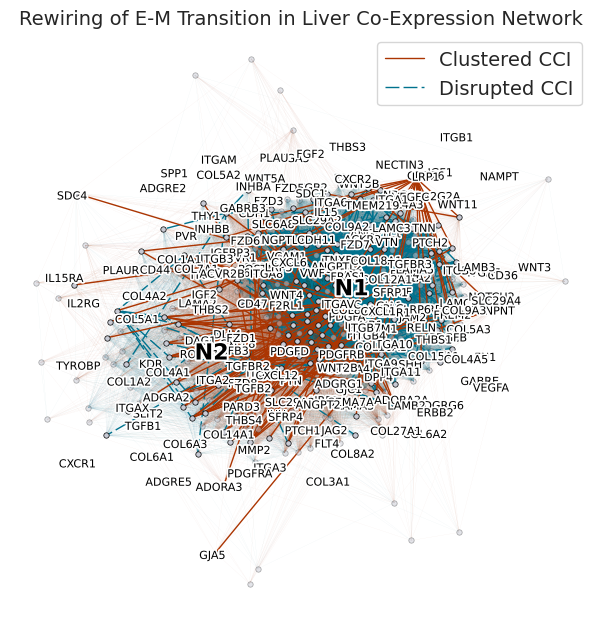

In [64]:
## import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
from adjustText import adjust_text
import networkx as nx

fs = 14
smallfs = 8

fig, ax = plt.subplots(1,1, figsize=(7.5, 7.5))

# Line width for edges
lw = 0.07
cci_lw = 1 # thicker line width for CCI edges

alpha = 0.18
cci_alpha = 1  # opacity for CCI edges

# Create the graph
G = nx.Graph()
color_map = {'tumor': tcolor, 'normal': ncolor, 'both': graycolor}

# Add edges with color and cci attributes
for _, row in filtered_edges.iterrows():
    G.add_edge(row['gene1'], row['gene2'], color=color_map[row['status']], cci=row['CCI'])

nx.set_node_attributes(G, module_names.to_dict(), name='module')
    
# Layout
pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, seed=42, k=1.2)

# Compute limits based on node positions to crop whitespace (crop whitespace)
x_values, y_values = zip(*pos.values())
x_margin = (max(x_values) - min(x_values)) * 0.05  # 5% margin
y_margin = (max(y_values) - min(y_values)) * 0.05

ax.set_xlim(min(x_values) - x_margin, max(x_values) + x_margin)
ax.set_ylim(min(y_values) - y_margin, max(y_values) + y_margin)

# Define labeled nodes as those in all_em_genes
#highlight_nodes = set(G.nodes()).intersection(all_em_genes)
highlight_nodes = set(G.nodes()).intersection(cci_genes)
non_highlight_nodes = set(G.nodes()) - highlight_nodes

nx.draw_networkx_nodes(G, pos, nodelist=non_highlight_nodes, node_size=15, node_color=lightgray, alpha=0.5, edgecolors=graycolor, linewidths=0.5)
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=15, node_color=lightgray, alpha=1, edgecolors='k', linewidths=0.5)

# Draw edges in two layers for alpha control
normal_edges = [(u, v) for u, v, d in G.edges(data=True) if not d.get('cci', False)]
cci_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('cci', False)]

normal_colors = [G[u][v]['color'] for u, v in normal_edges]
cci_colors = [G[u][v]['color'] for u, v in cci_edges]

nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color=normal_colors, width=lw, alpha=alpha)
#nx.draw_networkx_edges(G, pos, edgelist=cci_edges, edge_color=cci_colors, width=cci_lw, alpha=cci_alpha, style='dashed')

# Split CCI edges by color
cci_edges_normal = [(u, v) for u, v in cci_edges if G[u][v]['color'] == ncolor]
cci_edges_tumor = [(u, v) for u, v in cci_edges if G[u][v]['color'] == tcolor]

cci_colors_normal = [G[u][v]['color'] for u, v in cci_edges_normal]
cci_colors_tumor = [G[u][v]['color'] for u, v in cci_edges_tumor]

# Draw CCI edges: normal as dashed, tumor as solid
nx.draw_networkx_edges(G, pos, edgelist=cci_edges_normal, edge_color=cci_colors_normal, width=cci_lw, alpha=cci_alpha, style=(5, (10, 3)))
nx.draw_networkx_edges(G, pos, edgelist=cci_edges_tumor, edge_color=cci_colors_tumor, width=cci_lw, alpha=cci_alpha, style='solid')

# Draw labels only for highlight (EM-related) nodes
texts = []
points = []

for node in highlight_nodes:
    x, y = pos[node]
    texts.append(
        plt.text(x, y, node,
                 fontsize=smallfs, ha='center', va='center', zorder=10, color='black',
                 path_effects=[path_effects.Stroke(linewidth=2.5, foreground='white'),
                               path_effects.Normal()])
    )
    points.append([x, y])  # add node positions
    
# Legend
legend_elements = [
    Line2D([0], [0], color=tcolor, lw=cci_lw, linestyle='solid', label='Clustered CCI'),
    Line2D([0], [0], color=ncolor, lw=cci_lw, linestyle=(0, (10, 3)), label='Disrupted CCI'),
]

plt.legend(handles=legend_elements, loc='upper right', fontsize=fs)

plt.title("Rewiring of E-M Transition in Liver Co-Expression Network", fontsize=fs)
plt.axis('off')

adjust_text(texts, x=[p[0] for p in points], y=[p[1] for p in points], force_explode=(3,3), force_text=(1.5,1.5))

# Draw module name at centroid of each module
for module in module_names.unique():
    if str(module) in ['N1', 'N2']:
        module_nodes = [n for n, d in G.nodes(data=True) if d.get('module') == module and n in pos]
        if not module_nodes:
            continue
        # Compute average position of nodes in this module
        x = sum(pos[n][0] for n in module_nodes) / len(module_nodes)
        y = sum(pos[n][1] for n in module_nodes) / len(module_nodes)

        text = plt.text(x, y, str(module), fontsize=16, fontweight='bold', color='black', ha='center', va='center', zorder=99)
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='white'),
            path_effects.Normal()
        ])

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/em_network_liver.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/em_network_liver.png', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/supplementary/em_network_liver.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/supplementary/em_network_liver.png', dpi=300, bbox_inches='tight')

#adjust_text(texts, x=[p[0] for p in points], y=[p[1] for p in points],
#            expand_points=(1.2, 1.2), expand_text=(1.2, 1.2),
#            force_points=0.2, force_text=1.5)

plt.show()
